# Superposition by embedding bottleneck

This is an experiment to squash higher-dimensional data into a lower-dimensional embedding space. We'll start with color: RGB values (3 dimensions) ranging from 0..1. If we compress them into a 2D embedding, we should expect to see superposition, with directions interpretable as they would be in a classic color wheel: three primary color directions (RGB) spaced 120° apart.


In [234]:
from __future__ import annotations

## Simple MLP with bottleneck

We'll train a simple 2-layer MLP with low-dimensional bottleneck to map RGB values (inputs like [1.0, 0.0, 0.0] for red) to RGB values. This would force colors into an embedding space where we expect to see the superposition effect.

In [235]:
import torch
import torch.nn as nn


class ColorMLP(nn.Module):
    def __init__(self, normalize_bottleneck=False):
        super().__init__()
        # RGB input (3D) → hidden layer → bottleneck → hidden layer → RGB output
        self.encoder = nn.Sequential(
            nn.Linear(3, 16),
            nn.GELU(),
            # nn.Linear(16, 16),
            # nn.GELU(),
            nn.Linear(16, 3),  # Our critical bottleneck!
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, 16),
            nn.GELU(),
            # nn.Linear(16, 16),
            # nn.GELU(),
            nn.Linear(16, 3),
            nn.Sigmoid(),  # Keep RGB values in [0,1]
        )

        self.normalize = normalize_bottleneck

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        # Get our bottleneck representation
        bottleneck = self.encoder(x)

        # Optionally normalize to unit vectors (like nGPT)
        if self.normalize:
            norm = torch.norm(bottleneck, dim=1, keepdim=True)
            bottleneck = bottleneck / (norm + 1e-8)  # Avoid division by zero

        # Decode back to RGB
        output = self.decoder(bottleneck)
        return output, bottleneck

## Training machinery

In [236]:
from dataclasses import dataclass
from typing import Callable, Protocol, runtime_checkable
from torch import Tensor


@dataclass(eq=False)
class CurriculumPhase:
    name: str
    data: torch.Tensor
    epochs: int
    loss_terms: list[LossTerm]
    base_lr: float = 0.001
    warmup_fraction: float = 0.1
    hard_reset: bool = False


@dataclass
class LossTerm:
    name: str
    weight: float
    schedule: WeightSchedule
    criterion: Regularizer | DeltaRegularizer

    def calc_weight(self, epochs: int, epoch: int) -> float:
        return self.weight * self.schedule(epochs, epoch)


@dataclass
class InferenceResult:
    outputs: Tensor
    latents: Tensor

    def detach(self):
        return InferenceResult(self.outputs.detach(), self.latents.detach())

    def clone(self):
        return InferenceResult(self.outputs.clone(), self.latents.clone())

    def cpu(self):
        return InferenceResult(self.outputs.cpu(), self.latents.cpu())


class WeightSchedule(Protocol):
    def __call__(self, epochs: int, epoch: int) -> float: ...


@runtime_checkable
class Regularizer(Protocol):
    def __call__(self, data: Tensor, res: InferenceResult) -> Tensor: ...


class DeltaRegularizer:
    reference: str
    """The name of a reference phase to compare against"""

    def __call__(self, data: Tensor, current: InferenceResult, former: InferenceResult) -> Tensor: ...


def train_color_model(  # noqa: C901
    model: ColorMLP,
    curriculum: list[CurriculumPhase],
    plot: Callable[[CurriculumPhase, InferenceResult], None],
):
    from copy import deepcopy
    from time import time
    from torch import optim
    from torch.optim.lr_scheduler import LinearLR
    from tqdm.auto import tqdm

    initial_state = deepcopy(model.state_dict())

    # Create optimizer once for the entire training process
    optimizer = optim.Adam(model.parameters())

    phase_history: dict[str, tuple[CurriculumPhase, InferenceResult]] = {}

    total_epochs = sum(phase.epochs for phase in curriculum)

    with tqdm(total=total_epochs) as pbar:
        for phase in curriculum:
            last_plot_t = 0
            if phase.hard_reset:
                with torch.no_grad():
                    model.load_state_dict(initial_state)
                    # Phase start: reset model parameters and optimizer
                    # for p in model.parameters():
                    #     p.random_(-1, 1)
                optimizer = optim.Adam(model.parameters(), lr=phase.base_lr)

            else:
                for group in optimizer.param_groups:
                    group['lr'] = phase.base_lr

            warmup_epochs = max(1, int(phase.epochs * phase.warmup_fraction))
            scheduler = LinearLR(
                optimizer,
                start_factor=1 / warmup_epochs,
                end_factor=1.0,
                total_iters=warmup_epochs,
            )

            # Collect input data
            datasets: dict[str, Tensor] = {}
            for loss_term in phase.loss_terms:
                if isinstance(loss_term.criterion, DeltaRegularizer):
                    ref_phase, _ref_results = phase_history[loss_term.criterion.reference]
                    datasets[loss_term.criterion.reference] = ref_phase.data
                else:
                    datasets[phase.name] = phase.data

            for epoch in range(phase.epochs):
                pbar.update(1)
                optimizer.zero_grad()

                results: dict[str, InferenceResult] = {}
                for name, data in datasets.items():
                    outputs, latents = model(data)
                    results[name] = InferenceResult(outputs, latents)

                # Calculate loss (including regularization terms)
                losses: dict[str, Tensor] = {}
                for loss_term in phase.loss_terms:
                    weight = loss_term.calc_weight(phase.epochs, epoch)
                    if isinstance(loss_term.criterion, DeltaRegularizer):
                        key = loss_term.criterion.reference
                        ref_data = datasets[key]
                        curr_results = results[key]
                        prior_results = phase_history[key][1]
                        losses[loss_term.name] = weight * loss_term.criterion(ref_data, curr_results, prior_results)
                    else:
                        losses[loss_term.name] = weight * loss_term.criterion(datasets[phase.name], results[phase.name])
                loss = sum(losses.values(), start=torch.tensor(0.0))

                # Backward pass
                loss.backward()
                optimizer.step()
                scheduler.step()

                # current_lr = optimizer.param_groups[0]['lr']
                pbar.set_postfix(
                    {
                        'phase': phase.name,
                        'lr': f'{scheduler.get_last_lr()[0]:.6f}',
                        'loss': f'{loss.item():.4f}',
                        **{name: f'{lt.item():.4f}' for name, lt in losses.items()},
                    },
                )

                if time() > last_plot_t + 5:
                    plot(phase, results[phase.name].clone().detach().cpu())
                    last_plot_t = time()

            # Phase end: store results and plot
            with torch.no_grad():
                outputs, latents = model(phase.data)
                inference_result = InferenceResult(outputs, latents).detach()
                phase_history[phase.name] = (phase, inference_result)
                plot(phase, inference_result.clone().detach().cpu())

    return phase_history

In [237]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from torch import Tensor


def plot_latent_space(latents: Tensor, colors: Tensor, title: str, dim_pairs: list[tuple[int, int]] | None = None):
    """Plot the color space with RGB values across different dimension pairs"""
    _latents = latents.detach().cpu().numpy()
    _colors = colors.detach().cpu().numpy()

    if dim_pairs is None:
        dim_pairs = [(0, 1)]

    fig, axes = plt.subplots(1, len(dim_pairs), figsize=(5 * len(dim_pairs), 5), squeeze=False)
    axes = axes.flatten()

    for ax, (dim1, dim2) in zip(axes, dim_pairs, strict=True):
        ax.scatter(_latents[:, dim1], _latents[:, dim2], c=_colors, s=10, alpha=1)
        ax.set_title(f'{title} (Dims {dim1}, {dim2})')
        ax.set_xlabel(f'Dimension {dim1}')
        ax.set_ylabel(f'Dimension {dim2}')

        # Add main axis lines (x=0, y=0)
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
        # Add unit circle (r=1) to visualize normalization constraint
        ax.add_patch(Circle((0, 0), 1, fill=False, linestyle='--', color='gray', alpha=0.3))

        # Ensure equal scaling for better visualization of the color wheel
        ax.set_aspect('equal')

    fig.tight_layout()
    return fig


def plot_history(
    history: list[tuple[CurriculumPhase, InferenceResult]],
    dim_pairs: list[tuple[int, int]] | None = None,
):
    """Plot history as a series of subplots with different dimension combinations"""
    if dim_pairs is None:
        dim_pairs = [(0, 1), (0, 2)]

    fig, axes = plt.subplots(
        len(history),
        len(dim_pairs),
        figsize=(5 * len(dim_pairs), 5 * len(history)),
        squeeze=False,
    )

    for row_idx, (phase, res) in enumerate(history):
        _latents = res.latents.detach().cpu().numpy()
        _colors = phase.data.detach().cpu().numpy()

        for col_idx, (dim1, dim2) in enumerate(dim_pairs):
            ax = axes[row_idx, col_idx]
            ax.scatter(_latents[:, dim1], _latents[:, dim2], c=_colors, s=10, alpha=1)

            if col_idx == 0:
                ax.set_ylabel(phase.name)

            ax.set_xlabel(f'Dim {dim1}')
            ax.set_ylabel(f'Dim {dim2}')

            # Add main axis lines (x=0, y=0)
            ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
            ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
            # Add unit circle (r=1) to visualize normalization constraint
            ax.add_patch(Circle((0, 0), 1, fill=False, linestyle='--', color='gray', alpha=0.3))

            # Ensure equal scaling for better visualization of the color wheel
            ax.set_aspect('equal')

    # Add column titles at the top
    for col_idx, (dim1, dim2) in enumerate(dim_pairs):
        axes[0, col_idx].set_title(f'Dimensions {dim1} vs {dim2}')

    fig.tight_layout()
    return fig


def curriculum_plotter(phases: list[CurriculumPhase]):
    from utils.nb import displayer

    history: list[tuple[CurriculumPhase, InferenceResult]] = []
    display = displayer()
    dim_pairs = [(0, 1), (0, 2)]

    def plot(phase: CurriculumPhase, res: InferenceResult):
        if history and history[-1][0].name == phase.name:
            # Update the last phase in history
            history[-1] = (phase, res)
        else:
            history.append((phase, res))

        fig = plot_history(history, dim_pairs)
        fig.draw_without_rendering()
        display(fig)
        plt.close(fig)

    return plot

## Curriculum

In order to get a somewhat predictable orientation in latent space, we'll use curriculum learning:

| Phase | Training Data              | Regularization                       |
| ----- | -------------------------- | ------------------------------------ |
| 1     | Primary & secondary colors | Separation, normalization, planarity |
| 2     | All pure hues              | Anchor (weak)                        |
| 3     | Slightly darker hues       | Anchor (weak)                        |
| 4     | Extended brightness levels | Anchor (moderate), normalization     |
| 5     | More brightness levels     | Anchor, normalization                |
| 6     | Full brightness range      | Anchor, normalization                |

With this curriculum, we expect to see a strong, well-formed color wheel with just the hues. As we add the darker tones, it should more-or-less retain its shape, but the darker tones should appear as smaller rings further from the _hue_ plane. Viewed from the side, it should start to resemble a dome.

The constraints are applied as regularization terms. These ultimately form part of the loss function, but are calculated from the latent HSV embeddings rather than the reconstructed RGB outputs.

- Normalization: This uses the L2 norm in two ways:
  - First calculates the L2 norm of each latent vector
  - Then applies mean squared error between these norms and 1.0
  - This encourages all latent vectors to lie on a unit sphere
- Planar constriant: This is also L2-based:
  - Takes the squared values (i.e. L2 norm, not absolute values) of the remaining dimensions
  - This pushes the later dimensions toward zero, encouraging a planar representation

To reduce disruption to the embeddings learnt in the earlier phases, we'll use a learning rate scheduler. It will start each phase with a low learning rate that will ramp up over the first few epochs.


  0%|          | 0/23000 [00:00<?, ?it/s]

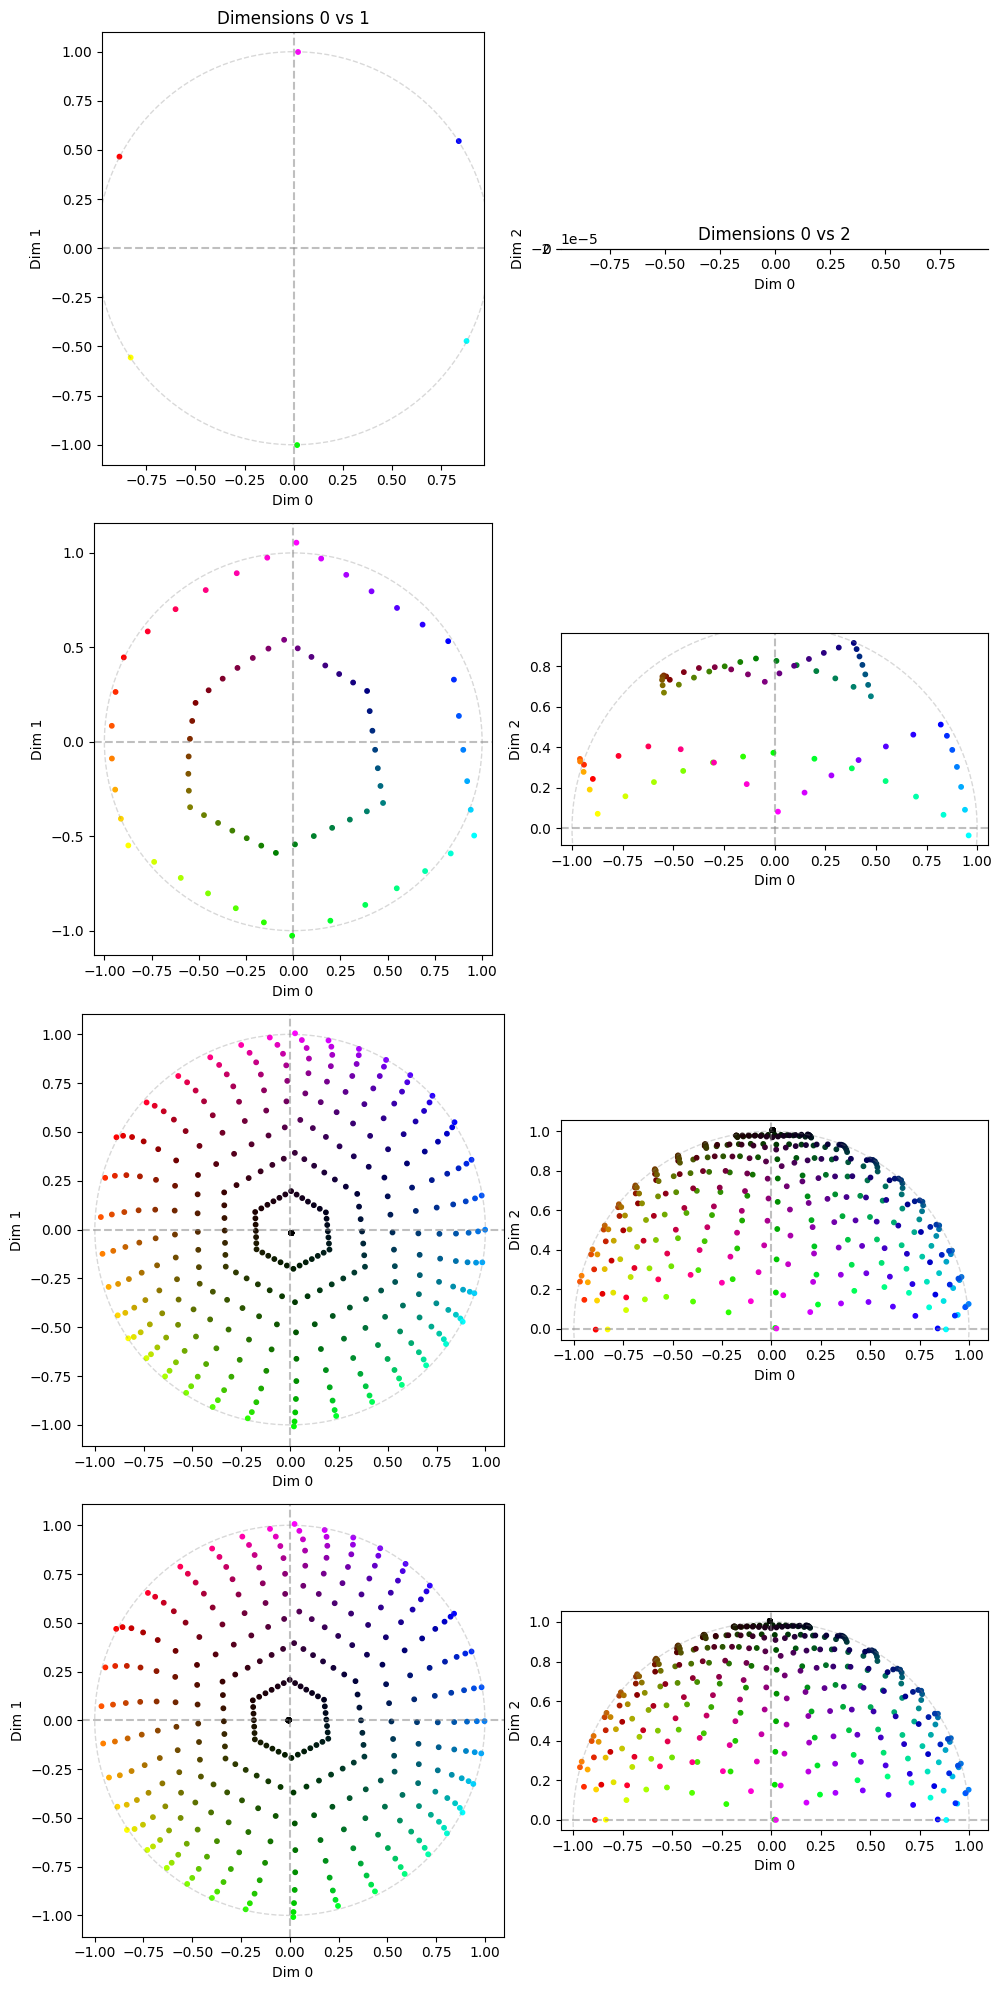

In [254]:
from typing import Literal
import numpy as np
import torch.nn as nn
from torch import linalg as LA

from ex_color.data import ColorCube, hue_arange


def objective(fn):
    """Adapt loss function to look like a regularizer"""

    def wrapper(data: Tensor, res: InferenceResult) -> Tensor:
        return fn(data, res.outputs)

    return wrapper


def unitary(data: Tensor, res: InferenceResult) -> Tensor:
    """Regularize latents to have unit norm (vectors of length 1)"""
    norms = LA.vector_norm(res.latents, dim=-1)
    return torch.mean((norms - 1.0) ** 2)


def planarity(data: Tensor, res: InferenceResult) -> Tensor:
    """Regularize latents to be planar in the first two channels (so zero in other channels)"""
    return torch.mean(res.latents[:, 2:] ** 2)


class Separate(Regularizer):
    def __init__(self, channels: tuple[int, ...] = (0, 1)):
        self.channels = channels

    def __call__(self, data: Tensor, res: InferenceResult) -> Tensor:
        """Regularize latents to be separated from each other in first two channels"""
        # Get pairwise differences in the first two dimensions
        points = res.latents[:, self.channels]  # [B, C]
        diffs = points.unsqueeze(1) - points.unsqueeze(0)  # [B, B, C]

        # Calculate squared distances
        sq_dists = torch.sum(diffs**2, dim=-1)  # [B, B]

        # Remove self-distances (diagonal)
        mask = 1.0 - torch.eye(sq_dists.shape[0], device=sq_dists.device)
        masked_sq_dists = sq_dists * mask

        # Encourage separation by minimizing inverse distances (stronger repulsion between close points)
        epsilon = 1e-6  # Prevent division by zero
        return torch.mean(1.0 / (masked_sq_dists + epsilon))


class Anchor(DeltaRegularizer):
    """Regularize latents to be close to their position in the reference phase"""

    def __init__(self, reference: str):
        self.reference = reference

    def __call__(self, data: Tensor, current: InferenceResult, former: InferenceResult) -> Tensor:
        return torch.mean((current.latents - former.latents) ** 2)


def const_schedule(epochs: int, epoch: int) -> float:
    return 1.0


class CosShedule(WeightSchedule):
    """Cosine weight schedule for regularization"""

    def __init__(self, cycles: int, finish: Literal['high', 'low']):
        self.cycles = cycles
        self.finish = finish

    def __call__(self, epochs: int, epoch: int) -> float:
        freq = self.cycles * 2
        if self.finish == 'high':
            freq += 1
        return (1 - np.cos(epoch / epochs * freq * np.pi)) / 2


class RampSchedule(WeightSchedule):
    """Ramp weight schedule for regularization"""

    def __init__(self, end_at: float):
        self.end_at = end_at

    def __call__(self, epochs: int, epoch: int) -> float:
        return epoch / epochs * self.end_at


curriculum = [
    CurriculumPhase(
        name='Primary, secondary',
        data=torch.tensor(
            ColorCube.from_hsv(
                h=hue_arange(step_size=1 / 6),
                s=np.array([1]),
                v=np.array([1]),
            )
            .permute('svh')
            .rgb_grid.reshape(-1, 3),
            dtype=torch.float32,
        ),
        epochs=1000,
        base_lr=0.01,
        loss_terms=[
            LossTerm('recon', 1.0, CosShedule(1, 'high'), objective(nn.MSELoss())),
            LossTerm('sep', 0.1, CosShedule(2, 'low'), Separate((0, 1))),
            LossTerm('norm', 0.3, CosShedule(3, 'low'), unitary),
            LossTerm('planar', 0.1, CosShedule(4, 'low'), planarity),
        ],
    ),
    CurriculumPhase(
        name='Primary, secondary',
        data=torch.tensor(
            ColorCube.from_hsv(
                h=hue_arange(step_size=1 / 6),
                s=np.array([1]),
                v=np.array([1]),
            )
            .permute('svh')
            .rgb_grid.reshape(-1, 3),
            dtype=torch.float32,
        ),
        epochs=1000,
        base_lr=0.001,
        warmup_fraction=0,
        loss_terms=[
            LossTerm('recon', 1.0, CosShedule(1, 'high'), objective(nn.MSELoss())),
            LossTerm('sep', 0.5, CosShedule(2, 'low'), Separate((0, 1))),
            LossTerm('norm', 0.1, CosShedule(3, 'low'), unitary),
            LossTerm('planar', 0.1, CosShedule(4, 'low'), planarity),
        ],
    ),
    CurriculumPhase(
        name='Primary, secondary',
        data=torch.tensor(
            ColorCube.from_hsv(
                h=hue_arange(step_size=1 / 6),
                s=np.array([1]),
                v=np.array([1]),
            )
            .permute('svh')
            .rgb_grid.reshape(-1, 3),
            dtype=torch.float32,
        ),
        epochs=1000,
        base_lr=0.0001,
        warmup_fraction=0,
        loss_terms=[
            LossTerm('recon', 0.1, CosShedule(1, 'high'), objective(nn.MSELoss())),
            LossTerm('norm', 1.0, CosShedule(2, 'high'), unitary),
            LossTerm('planar', 1.0, CosShedule(3, 'high'), planarity),
        ],
    ),
    CurriculumPhase(
        name='BCO',
        data=torch.tensor(
            ColorCube.from_hsv(
                h=hue_arange(step_size=10 / 360),
                s=np.array([1]),
                v=np.array([0.9, 1]),
            )
            .permute('svh')
            .rgb_grid.reshape(-1, 3),
            dtype=torch.float32,
        ),
        epochs=1000,
        base_lr=0.0001,
        warmup_fraction=0,
        loss_terms=[
            LossTerm('recon', 0.01, CosShedule(0, 'high'), objective(nn.MSELoss())),
            LossTerm('norm', 1.0, CosShedule(0, 'high'), unitary),
            LossTerm('anchor', 0.1, const_schedule, Anchor('Primary, secondary')),
        ],
    ),
    CurriculumPhase(
        name='BCO',
        data=torch.tensor(
            ColorCube.from_hsv(
                h=hue_arange(step_size=10 / 360),
                s=np.array([1]),
                v=np.array([0.8, 1]),
            )
            .permute('svh')
            .rgb_grid.reshape(-1, 3),
            dtype=torch.float32,
        ),
        epochs=1000,
        base_lr=0.0001,
        warmup_fraction=0,
        loss_terms=[
            LossTerm('recon', 0.01, CosShedule(0, 'high'), objective(nn.MSELoss())),
            LossTerm('norm', 1.0, CosShedule(0, 'high'), unitary),
            LossTerm('anchor', 0.1, const_schedule, Anchor('Primary, secondary')),
        ],
    ),
    CurriculumPhase(
        name='BCO',
        data=torch.tensor(
            ColorCube.from_hsv(
                h=hue_arange(step_size=10 / 360),
                s=np.array([1]),
                v=np.array([0.5, 1]),
            )
            .permute('svh')
            .rgb_grid.reshape(-1, 3),
            dtype=torch.float32,
        ),
        epochs=1000,
        base_lr=0.0001,
        warmup_fraction=0.1,
        loss_terms=[
            LossTerm('recon', 0.05, CosShedule(0, 'high'), objective(nn.MSELoss())),
            LossTerm('norm', 1.0, CosShedule(0, 'high'), unitary),
            LossTerm('anchor', 0.1, const_schedule, Anchor('Primary, secondary')),
        ],
    ),
    CurriculumPhase(
        name='BCO',
        data=torch.tensor(
            ColorCube.from_hsv(
                h=hue_arange(step_size=10 / 360),
                s=np.array([1]),
                v=np.array([0.5, 1]),
            )
            .permute('svh')
            .rgb_grid.reshape(-1, 3),
            dtype=torch.float32,
        ),
        epochs=1000,
        base_lr=0.0001,
        warmup_fraction=0.1,
        loss_terms=[
            LossTerm('recon', 0.1, CosShedule(0, 'high'), objective(nn.MSELoss())),
            LossTerm('norm', 1.0, CosShedule(0, 'high'), unitary),
            LossTerm('anchor', 0.3, const_schedule, Anchor('Primary, secondary')),
        ],
    ),
    CurriculumPhase(
        name='Final',
        data=torch.tensor(
            ColorCube.from_hsv(
                h=hue_arange(step_size=10 / 360),
                s=np.array([1]),
                v=np.linspace(0, 1, 10),
            )
            .permute('svh')
            .rgb_grid.reshape(-1, 3),
            dtype=torch.float32,
        ),
        epochs=1000,
        base_lr=0.0001,
        warmup_fraction=0,
        loss_terms=[
            LossTerm('recon', 1.0, CosShedule(0, 'high'), objective(nn.MSELoss())),
            LossTerm('anchor', 0.1, const_schedule, Anchor('Primary, secondary')),
        ],
    ),
    CurriculumPhase(
        name='Final',
        data=torch.tensor(
            ColorCube.from_hsv(
                h=hue_arange(step_size=10 / 360),
                s=np.array([1]),
                v=np.linspace(0, 1, 10),
            )
            .permute('svh')
            .rgb_grid.reshape(-1, 3),
            dtype=torch.float32,
        ),
        epochs=5000,
        base_lr=0.001,
        warmup_fraction=0,
        loss_terms=[
            LossTerm('recon', 1.0, const_schedule, objective(nn.MSELoss())),
            LossTerm('norm', 1.0, CosShedule(0, 'high'), unitary),
            LossTerm('anchor', 0.1, const_schedule, Anchor('Primary, secondary')),
        ],
    ),
    CurriculumPhase(
        name='Final 2!',
        data=torch.tensor(
            ColorCube.from_hsv(
                h=hue_arange(step_size=10 / 360),
                s=np.array([1]),
                v=np.linspace(0, 1, 10),
            )
            .permute('svh')
            .rgb_grid.reshape(-1, 3),
            dtype=torch.float32,
        ),
        epochs=10000,
        base_lr=0.0001,
        # warmup_fraction=0,
        loss_terms=[
            LossTerm('recon', 1.0, const_schedule, objective(nn.MSELoss())),
            LossTerm('norm', 1.0, const_schedule, unitary),
            LossTerm('anchor', 0.1, const_schedule, Anchor('Primary, secondary')),
        ],
    ),
]

model = ColorMLP(normalize_bottleneck=False)

history = train_color_model(
    model,
    curriculum,
    curriculum_plotter(curriculum),
)